<a href="https://colab.research.google.com/github/CoAxLab/Data-Explorations/blob/main/book/exercises/classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 9: Classification

This homework assignment is designed to give you practice with classification models. We'll try to predict which words are more likely to be responded to correctly during a lexical decision task, based on their length and frequency.

We will be using data from the English Lexicon Project again. However, this time we will use response correctness as our dependent variable. Load **LexicalData_withIncorrect.csv**, which includes incorrect trials as well as correct ones, and also **Items.csv**. Both can be found in the *Homework/lexDat* folder in the class GitHub repository. 

This data is a subset of the [English Lexicon Project database](https://elexicon.wustl.edu/). It provides response correctness and reaction times (in milliseconds) of many subjects as they are presented with letter strings and asked to decide, as quickly and as accurately as possible, whether the letter string is a word or not. The **Items.csv** provides characteristics of the words used, namely frequency (how common is this word?) and length (how many letters?). 

*Data courtesy of Balota, D.A., Yap, M.J., Cortese, M.J., Hutchison, K.A., Kessler, B., Loftis, B., Neely, J.H., Nelson, D.L., Simpson, G.B., & Treiman, R. (2007). The English Lexicon Project. Behavior Research Methods, 39, 445-459.*

---
## 1. Loading and formatting the data (1 point)

Load in data from the **LexicalData_withIncorrect.csv** and **Items.csv** files. Use `left_join` to add word characteristics `Length` and `Log_Freq_Hal` from **Items** to the **LexicalData**, and use `drop_na()` to get rid of any observations with missing values. Then use `head()` to look at the first few rows of the data. 

*Note: We're just working with `Correct` in this homework, so no need to worry about reformatting reaction times.*

In [46]:
library(tidyverse)
setwd("/Users/letian/Desktop/huang_DSPN_S25/Homework")

Items <- read.csv("Items.csv")
LexicalData <- read.csv("LexicalData_withIncorrect.csv")

Items_tojoin <- Items %>%
    select(Length, Log_Freq_HAL, Word) %>%
    rename(D_Word = Word)

LexicalData_joined <- LexicalData %>%
    left_join(Items_tojoin, by = "D_Word")

LexicalData_new <- drop_na(LexicalData_joined)

head(LexicalData_new)


,X,Sub_ID,Trial,Type,D_RT,D_Word,Outlier,D_Zscore,Correct,Length,Log_Freq_HAL
,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>
1,1,157,1,1,710,browse,false,-0.437,1,6,8.856
2,2,67,1,1,"1,094",refrigerant,false,0.825,1,11,4.644
3,3,120,1,1,587,gaining,false,-0.645,1,7,8.304
4,4,21,1,1,984,cheerless,false,0.025,1,9,2.639
5,5,236,1,1,577,pattered,false,-0.763,1,8,1.386
6,6,236,2,1,715,conjures,false,-0.364,1,8,5.268


---
## 2. Visualizing the data (1 point)

First, we'll try to visualize whether trials that are responded to correctly versus incorrectly differ from each other in terms of word length and log frequency. The code is included below, so that this homework doesn't get too cumbersome. All you have to do is **change the name of the data set**, **run the code**, and **write some observations about the output**.

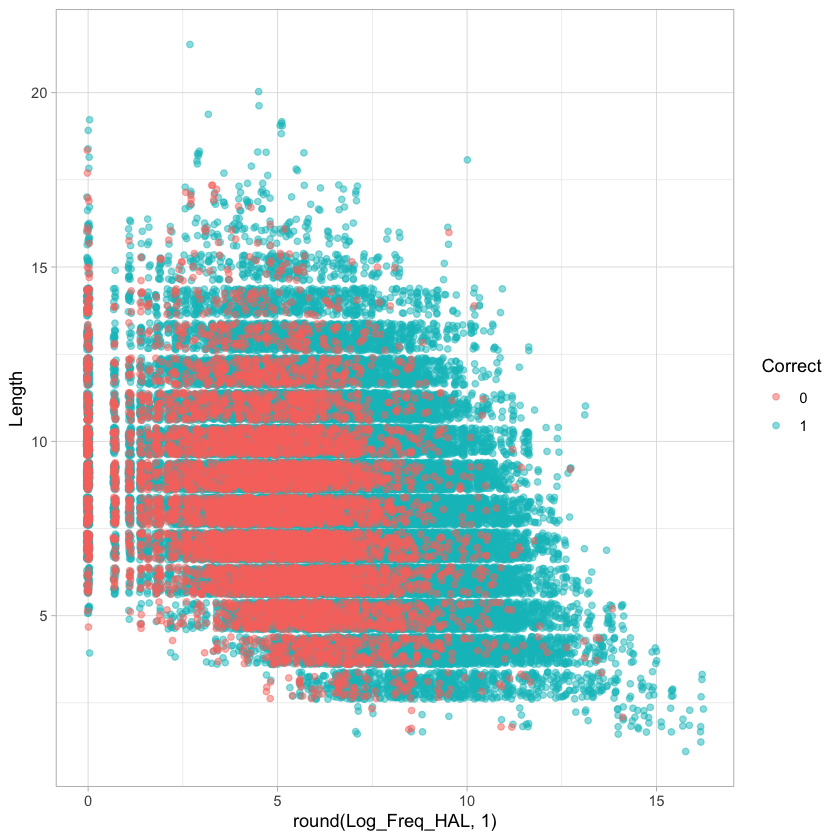

In [101]:
# vrequire(tidyverse) # Load the tidyverse package, if you haven't yet
LexicalData_new$Correct <- as.factor(LexicalData_new$Correct) # so that R knows that Correct is categorical, not numeric. 

# plot the Correct / Incorrect clusters
ggplot(LexicalData_new,aes(x=round(Log_Freq_HAL,1),y=Length,col=Correct)) + geom_point(position="jitter",alpha=0.5) + theme_light() 


What do you observe about the "Correct" and "Incorrect" clusters? 

> Correct cluster spans a larger range of frequency (y-axis) than incorrect cluster, which probably means that when a word is high in frequency (i.e., more commonly used), people are more likely to recognize it correctly as a word.

---
## 3. Logistic Regression: Fitting the model (2 points)

Fit a logistic regression model to the data using `Length`, `Log_Freq_HAL`, and their interaction to predict `Correct`. Use `glm()` to fit the model, and look at its output using `summary()`.

In [107]:
glm_mod = glm(Correct ~ Length * Log_Freq_HAL, data = LexicalData_new, family = binomial)
summary(glm_mod)


Call:
glm(formula = Correct ~ Length * Log_Freq_HAL, family = binomial, 
    data = LexicalData_new)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.939996   0.115623  -8.130 4.30e-16 ***
Length               0.151266   0.012789  11.828  < 2e-16 ***
Log_Freq_HAL         0.394772   0.018762  21.041  < 2e-16 ***
Length:Log_Freq_HAL -0.010558   0.002202  -4.795 1.63e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49809  on 70588  degrees of freedom
Residual deviance: 46563  on 70585  degrees of freedom
AIC: 46571

Number of Fisher Scoring iterations: 5


What can you conclude from this output? (a brief gist is fine)

> The output suggests that both length and frequency of a word predicts the correctness of one's response. The longer and more common a word is, the more correct one's response is. Additionally, the interaction term is significant, which means that the effect of length on correctness depends on the frequency of the word (and vice versa, the effect of frequency on correctness depends on the words' length). When the word is very common, the length of the word doesn't contribute much to one's response correctness; when the word is not common, the longer a word, the more correct one's response is.

---
## 4. Interpreting predictions from the model (3 points)

Finally, look at how well this logistic regression model does at predicting correctness. Use `predict()` and a threshold of 0.5 to generate predicted `Correct` values for each trial, then output a confusion matrix and overall accuracy for these predictions.

*Hint: see the Classifiers tutorial.*

           actual
predicted       0     1
  Correct    7966 62566
  Incorrect    13    44

[1] "Accuracy: 0"


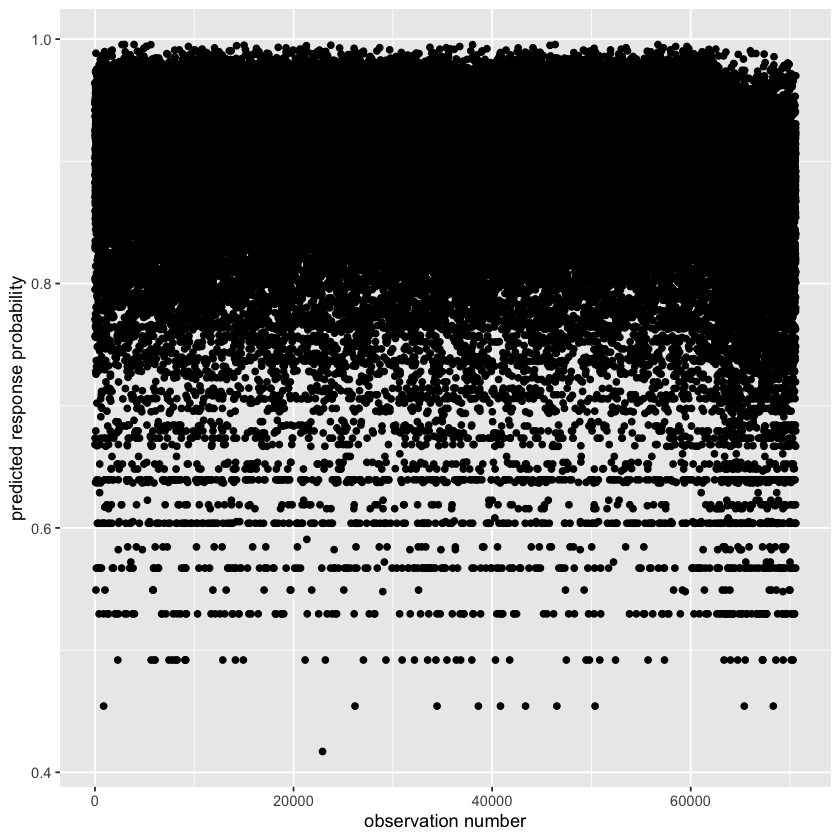

In [126]:
glm_prob_df = data.frame(predict(glm_mod, type = "response"))
colnames(glm_prob_df) = c('predicted_prob')
glm_prob_df$predicted_binary = rep("Incorrect", nrow(glm_prob_df))

glm_prob_df$predicted_binary[glm_prob_df$predicted_prob > .50] = "Correct"

confusion_df = data.frame(glm_prob_df$predicted_binary, LexicalData_new$Correct)
colnames(confusion_df) = c('predicted', 'actual')

table(confusion_df)
print(paste("Accuracy:", mean(confusion_df$predicted == confusion_df$actual)))

# visualization
glm_prob_df$index = seq(1, nrow(glm_prob_df))
ggplot(glm_prob_df, aes(index, predicted_prob)) + geom_point() + xlab('observation number') + ylab('predicted response probability')

Did the model do well at predicting lexical decision correctness? Why or why not? 

> The model didn't do well at predicting lexical decision correctness because it predicted almost every response to be correct when the threshold was set at 0.5, which makes the accuracy of prediction very low.

## 5. QDA (3 points)

Load in the `MASS` library and fit a QDA model to the data set. The predictors are still `Length`, `Log_Freq_HAL`, and their interaction, just like the logistic regression model you just ran, and the dependent variable is still `Correct`. 

*Hint: see the Classifiers tutorial.*

In [ ]:
library(MASS)
qda_mod = qda(Correct ~ Length * Log_Freq_HAL, data = LexicalData_new)
qda_mod

Call:
qda(Correct ~ Length * Log_Freq_HAL, data = LexicalData_new)

Prior probabilities of groups:
        0         1 
0.1130346 0.8869654 

Group means:
    Length Log_Freq_HAL Length:Log_Freq_HAL
0 8.047124     4.932123            37.95260
1 7.979971     6.444849            49.34219

Now look at how well the predicted `Correct` values compare with actual `Correct` values for the whole data set. Output a confusion matrix and overall prediction accuracy. 

In [125]:
qda_class=predict(qda_mod, LexicalData_new)$class
table(qda_class, LexicalData_new$Correct)
print(paste("Accuracy:", mean(qda_class == LexicalData_new$Correct)))

         
qda_class     0     1
        0   455  1647
        1  7524 60963

[1] "Accuracy: 0.870078907478502"


How does QDA prediction performance differ from that of logistic regression?

> QDA prediction performance is much better than that of logistic regression (.87 compared to 0).

**DUE:** 5pm EST, March 11, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Someone's Name*